This notebook provides a summary of our approach to the project, with any issues we face and limitations/assumptions made.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

data_directory = "../data/curated/"
merchants = pd.read_parquet(data_directory + "merchants.parquet")
transactions = pd.read_parquet(data_directory + "transactions.parquet")
consumers = pd.read_parquet(data_directory + "consumers.parquet")
census = pd.read_csv(data_directory + "census.csv")

In [5]:
def read_transactions(transactions_directories):
    return pd.concat([pd.read_parquet(trans_dir) for trans_dir in transactions_directories])

transaction_paths  = ['../data/tables/transactions_20210228_20210827_snapshot/', '../data/tables/transactions_20210828_20220227_snapshot/', '../data/tables/transactions_20220228_20220828_snapshot']
raw_transactions = read_transactions(transaction_paths)

# Normalisation

Firstly, we noticed an issue with the merchant dataset: the 'tags' column held a lot of data in an uncleaned string - it required both cleaning and normalisation so we could individually use all of the data contained in the tags field, which would be useful in ranking and segmentation later on (for example, take-rate, revenue band and category of purchase may all be relevant when ranking and, ideally, should be in different columns).

Hence, a normalisation procedure was conducted on this column and the corresponding ETL implementation was done, too.

In [6]:
merchants.head()

,name,tags,sector_tags,revenue_band,take_rate
merchant_abn,,,,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...","cable, satellite, and other pay television and...",b,4.22
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",b,4.40
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...","watch, clock, and jewelry repair shops",b,3.29
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.33


# Preprocessing/Outlier Analysis

After downloading/extracting the relevant datasets that were provided to us and conducting some preliminary analysis, the first step was to examine outliers and determine a method to eliminate them from the dataset. 

We found that, after merging transactions with merchants, the nulls are predominantly related to the name of the merchant and what they purchased ('tags'). At the preliminary stage, it was determined that these can be considered vital features when ranking merchants, and if we lack this data, we hinder the accuracy of our selection metrics. Hence, all nulls were removed from further analysis.

To conduct further outlier analysis, we utilised a histogram to visualise the anomalies present(outliers taken out per merchant):

In [14]:
#def get_outliers(column):
#    q1 = np.percentile(column, 25)
#    q3 = np.percentile(column, 75) 
#    IQR = q3 - q1
#    return sum((column<(q1 - IQR)) | (column>(q3 + IQR)))
def is_outlier(merchant):
    Q3 = np.quantile(merchant,0.75)
    Q1 = np.quantile(merchant,0.25)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    return ~merchant.between(lower_limit, upper_limit)

transactions_noNull = raw_transactions.merge(merchants, on='merchant_abn').dropna()

transactions_outliers = transactions_noNull[transactions_noNull.groupby('name')['dollar_value'].apply(is_outlier)]
transactions_outliers_grouped = transactions_outliers.groupby('name').agg(outlier_counts=pd.NamedAgg(column='order_id', aggfunc='count')).reset_index()
transactions_outliers_grouped

,name,outlier_counts
0,A Aliquet Ltd,36
1,A Arcu Industries,85
2,A Arcu Sed Company,39
3,A Arcu Sed Corporation,1
4,A Associates,2
...,...,...
3318,Vulputate Ullamcorper Magna LLC,3
3319,Vulputate Ullamcorper Magna Ltd,2
3320,Vulputate Velit Eu Incorporated,1
3321,Vulputate Velit Eu Limited,581


(0.0, 400.0)

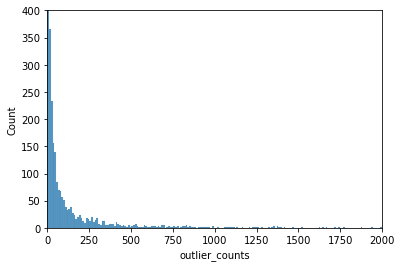

In [19]:
sns.histplot(data = transactions_outliers_grouped, x='outlier_counts')
plt.xlim(0,2000)
plt.ylim(0,400)

We see that there are outliers present in the data after locating them from their respective merchants.

To eliminate the observed outliers, an IQR statistical implementation was used, resulting in approximately 3% of all data (113982 rows) being removed.

Complementing all these steps, a generic ETL script was being updated using separate functions for obtaining and preprocessing the data.

### Using a Fraud Model to Further Remove Data

After the release of the fraud dataset, we wanted to implement a model that detects fraudulent transactions and also removes them from the dataset. As the fraud data is only a subset of transactions deemed suspicious, we will deal with outliers that represent those transactions deemed suspicious based on our analysis, instead of the entire dataset. Outliers were chosen as representation as we found that the transactions deemed suspicious were coming from outliers pertaining to each consumer as seen below (took a random sample of 100 consumers).

(-0.5, 773.5, 543.5, -0.5)

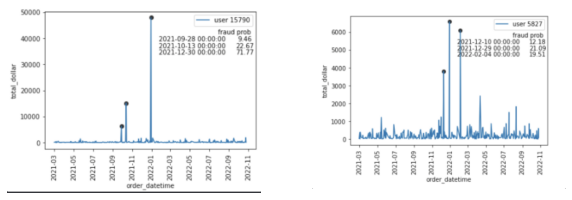

In [26]:
import matplotlib.image as mpimg

img1 = mpimg.imread('../plots/fraud_detection_1.png')
img2 = mpimg.imread('../plots/fraud_detection_2.png')
fig,ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')

In order to identify outliers, we had to normalise the dollar values according to each customer using Median and Quantile Scaling, and then train a linear regression model on the transaction-fraud data. Then, we would apply this model to the outliers (dollar values >$2 after the scaling) in the rest of the dataset. In the end, we used the predicted probability in conjunction with a randomly generated probability to remove the fraud data (for example, if probability of fraud is 60%, then there is a 60% chance it will be removed from the dataset).

In the final ETL, the fraud removal was done before the IQR-based outlier removal outlined above.

### External Dataset

The external dataset (census data) was retrieved from the ABS website. We believed that some of these features could prove useful in deriving a ranking model. Additionally, as the census data linked customer data by postcode and gender, it is assumed that this average is representative of the individual.

Due to the hundreds of features available, feature engineering was done in order to obtain the most predictive attributes of a consumer. For example, a house-repayment-to-income ratio was deemed important as it showcases how risky - or how likely to default - a consumer is, and was engineered by dividing median mortgage payment of a consumer by their median income.

The data was then cleaned and merged into other datasets.

During merging we found that the corresponding postcodes of many of the customers were not found in the census data, and with some further investigation it was found that these postcodes were not valid postcodes for people to live in, and hence consumers with those postcodes and their linked transactions were removed.

 ### Final (Merged) Dataset

By the preprocessing and outlier analysis detailed above for each dataset, we were able to obtain a final dataset by merging.

The ETL script was finalised, also. 

In [3]:
merged_transactions = pd.read_parquet(data_directory + "merged_transactions.parquet")
merged_transactions.head(10)

,user_id,merchant_abn,dollar_value,order_id,order_datetime,merchant_name,tags,sector_tags,revenue_band,take_rate,...,state,postcode,gender,Median_tot_hhd_inc_weekly,nill_income_percent_F,nill_income_percent_M,Median_age_persons,high_income_proportion,Median_mortgage_repay_monthly,house_repay_to_income
0,20864,28000487688,378.937918,f7eca4c5-474b-4ab2-ad61-6a8219b26d67,2021-02-28,Sed Nunc Industries,"((books, periodicals, anD newspapers), (b), (t...","books, periodicals, and newspapers",b,4.24,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
1,20864,62191208634,105.275480,0965a716-5365-4142-9e01-bf2312cc6a9e,2021-06-30,Cursus Non Egestas Foundation,"[(furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",c,2.17,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
2,20864,62191208634,15.615912,221aa65a-ae0e-4a09-a729-a671443457b5,2022-02-21,Cursus Non Egestas Foundation,"[(furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",c,2.17,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
3,20864,83690644458,97.497376,5a556b74-01c0-4e33-95e0-6bc71becffc5,2021-02-28,Id Erat Etiam Consulting,"[(gift, card, novelty, and souvenir shops), (b...","gift, card, novelty, and souvenir shops",b,3.15,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
4,20864,83690644458,69.286983,08c7cfed-0b51-4346-93fa-1691815f4b02,2022-05-25,Id Erat Etiam Consulting,"[(gift, card, novelty, and souvenir shops), (b...","gift, card, novelty, and souvenir shops",b,3.15,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
5,20864,80779820715,21.201432,bce357b2-6522-491b-839d-a270aee9dc92,2022-06-15,Euismod Enim LLC,"([watch, clock, and jewelry repair shops], [b]...","watch, clock, and jewelry repair shops",b,4.71,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
6,20864,43186523025,36.608689,52af5c7b-97fc-408b-ac46-b8b23fe7ec2a,2021-03-08,Lorem Ipsum Sodales Industries,"([florists supplies, nurSery stock, and flower...","florists supplies, nursery stock, and flowers",b,4.47,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
7,20864,43186523025,59.204581,4c46ed60-196e-4561-9bd4-3cae0aea1c5a,2021-05-21,Lorem Ipsum Sodales Industries,"([florists supplies, nurSery stock, and flower...","florists supplies, nursery stock, and flowers",b,4.47,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
8,20864,43186523025,101.042531,d6864a89-3932-49e7-96c3-a78c68d48e64,2021-08-30,Lorem Ipsum Sodales Industries,"([florists supplies, nurSery stock, and flower...","florists supplies, nursery stock, and flowers",b,4.47,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997
9,20864,43186523025,62.163660,5cc5957e-d6e0-4da3-95ab-01b0a5d70d00,2021-12-03,Lorem Ipsum Sodales Industries,"([florists supplies, nurSery stock, and flower...","florists supplies, nursery stock, and flowers",b,4.47,...,QLD,4113,Female,1823.0,0.114313,0.074165,35.0,0.072483,1730.0,0.218997


# The Ranking Model and Segmentations

Initially, we devised a metric using three models: Customer-Merchant Model (CN), Customer Number Model (CNM) and Customer Sampling Model (CS). The CN model would be used to predict the amount each cutomer-merchant pair would spend on a monthly basis; the CNM model in conjunction with CS would be used to predict revenue for a specific month (using a Monte-Carlo sampling method). Ultimately, we would use all of this information to predict the future revenue for any given month for a specific merchant. However, we faced a number of issues in creation of this system:
- Customer were sparse: we found that each customer only had a few transactions per merchant, hence making it difficult to derive a predictive power
- Memory/Technical Issues: since these databases/operations were computationally heavy, we were met with several RAM issues across group members, as well as .env and environment errors which impeded the creation process significantly
- A simple test model trained on a subset of the available data yielded an R^2 value of 0.01 on a test dataset, which we interpreted as an unsatisfactory number

As a result, we decided to change the model to the one we have now. By using several, reputable articles and studies, we were able to select and create features:
- Prevalent in Afterpay's annual report was the notion that the majority of revenue comes from the take-rate - hence, highlighting the fact that this should be the most important aspect of our model
- Customer Retention served as a distinguishing factor amongst the top chosen merchants - some merchants with comparitively lower revenue scores were still pinpointed by our model due to the comparatively higher retention score, which is an interesting discovery
    - Overall Customer Retention was calculated by taking the average customer retention, (Cust_end - Cust_new)/Cust_start, over each half year where Cust_end is the number of customers at the end of the time period, Cust_new is new customers gained during the time period and Cust_start is number of customers at start of time period
- Momentum, the difference between the latest and previous 6 month SMA of a merchant was also used in our model as an indicator of how well a given merchant would continue doing in future
- Research also revealed characteristics of BNPL customers which was accounted for in our Customer Quality metric:
    - Federal Reserve Bank of Philadelphia stated that the BNPL market is far more attractive to the younger audience
    - Federal Reserve Bank of Philadelphia also advised us to avoid nil income customers as they are likely to default
    - Seek low mortgage-income ratio, as mortgage stress is a strong indicator of financial position
    - Roy Morgan (reputable market research company) stated avoid high income customers as they are unlikely to use a BNPL approach

This research prompted us to weight the features accordingly. In regard to the Customer Quality metric, we found it interesting how amongst the top merchants, the mean quality of customers converges to the mean of the individual customer quality distribution. The implication is that each merchant's customers are chosen randomly from the overall customer distribution. Possibly with more realistic data, this would be more useful. 

(INSERT A VISUAL THAT SHOWCASES THE CONVERGING CUSTOMER QUALITY STUFF)

Below is our final ranking of merchants: 

In [7]:
import pandas as pd
rankings = pd.read_csv('../results/rankings.csv')
rankings.head(10)

,merchant_abn,name,sector_tags,retention,momentum_score,revenue_score,customer_quality,score
0,86578477987,Leo In Consulting,"watch, clock, and jewelry repair shops",0.969028,0.580496,0.952110,0.770702,0.880765
1,32361057556,Orci In Consequat Corporation,"gift, card, novelty, and souvenir shops",0.664392,0.616855,1.000000,0.774540,0.869641
2,64403598239,Lobortis Ultrices Company,"music shops - musical instruments, pianos, and...",0.773248,0.602984,0.965683,0.764959,0.862341
3,89726005175,Est Nunc Consulting,tent and awning shops,0.937524,0.613811,0.861313,0.766881,0.826176
4,21439773999,Mauris Non Institute,"cable, satellite, and other pay television and...",0.780963,0.595851,0.894282,0.777622,0.820854
5,45629217853,Lacus Consulting,"gift, card, novelty, and souvenir shops",0.941055,0.575384,0.819798,0.763485,0.795693
6,48534649627,Dignissim Maecenas Foundation,"opticians, optical goods, and eyeglasses",0.560206,0.614034,0.858046,0.763377,0.767301
7,94493496784,Dictum Phasellus In Institute,"gift, card, novelty, and souvenir shops",0.717041,0.584147,0.815619,0.769235,0.761473
8,49322182190,Gravida Mauris Incorporated,"watch, clock, and jewelry repair shops",0.492738,0.578918,0.862436,0.762769,0.754487
9,96680767841,Ornare Limited,motor vehicle supplies and new parts,0.328149,0.564826,0.897430,0.780714,0.750476


### Segmentations

Our segmentations are based on a report by Citibank which highlighted different Merchant Category Codes and provided descriptions for each one. 

For reference: https://www.citibank.com/tts/solutions/commercial-cards/assets/docs/govt/Merchant-Category-Codes.pdf

We simply viewed all the sector tags in our dataset and placed them under the specifc merchant category by matching descriptions from the report.

Below are our segments:

In [19]:
business = pd.read_csv('../results/Business Services_rankings.csv')
misc = pd.read_csv('../results/Miscellaneous Stores_rankings.csv')
prof = pd.read_csv('../results/Professional services and membership organisations_rankings.csv')
retail = pd.read_csv('../results/Retail outlet services_rankings.csv')
utility = pd.read_csv('../results/Utility services_rankings.csv')

In [14]:
#Business Services Segment Ranking
business.head()

,merchant_abn,name,sector_tags,retention,momentum_score,revenue_score,customer_quality,score
0,35909341340,Arcu Sed Eu Incorporated,"computer programming , data processing, and in...",0.377500,0.597597,0.708582,0.744300,0.645844
1,58454491168,Diam At Foundation,"computer programming , data processing, and in...",0.279798,0.483744,0.617034,0.767027,0.561454
2,67400260923,Eleifend PC,"computer programming , data processing, and in...",0.381212,0.562784,0.502232,0.764662,0.519405
3,77590625261,Sed Diam Foundation,"computer programming , data processing, and in...",0.272368,0.632808,0.387516,0.761563,0.444442
4,94455880010,Nunc Sit LLC,"computer programming , data processing, and in...",0.287177,0.541501,0.231515,0.766321,0.339843


In [15]:
#Miscellaneous Stores Segment Ranking
misc.head()

,merchant_abn,name,sector_tags,retention,momentum_score,revenue_score,customer_quality,score
0,86578477987,Leo In Consulting,"watch, clock, and jewelry repair shops",0.969028,0.580496,0.952110,0.770702,0.880765
1,32361057556,Orci In Consequat Corporation,"gift, card, novelty, and souvenir shops",0.664392,0.616855,1.000000,0.774540,0.869641
2,64403598239,Lobortis Ultrices Company,"music shops - musical instruments, pianos, and...",0.773248,0.602984,0.965683,0.764959,0.862341
3,89726005175,Est Nunc Consulting,tent and awning shops,0.937524,0.613811,0.861313,0.766881,0.826176
4,45629217853,Lacus Consulting,"gift, card, novelty, and souvenir shops",0.941055,0.575384,0.819798,0.763485,0.795693


In [16]:
#Professional Services Segment Ranking
prof.head()

,merchant_abn,name,sector_tags,retention,momentum_score,revenue_score,customer_quality,score
0,48534649627,Dignissim Maecenas Foundation,"opticians, optical goods, and eyeglasses",0.560206,0.614034,0.858046,0.763377,0.767301
1,46804135891,Suspendisse Dui Corporation,"opticians, optical goods, and eyeglasses",0.944943,0.580593,0.288396,0.764694,0.478337
2,95574756848,At Pede Inc.,"opticians, optical goods, and eyeglasses",0.133073,0.569563,0.373195,0.771369,0.406450
3,92065881715,Quam Elementum Corp.,"opticians, optical goods, and eyeglasses",0.107265,0.613529,0.190654,0.765458,0.299057
4,11237511112,Magna Institute,"opticians, optical goods, and eyeglasses",0.225500,0.605133,0.137054,0.764276,0.283255


In [17]:
#Retail Outlet Services Segment Ranking
retail.head()

,merchant_abn,name,sector_tags,retention,momentum_score,revenue_score,customer_quality,score
0,96680767841,Ornare Limited,motor vehicle supplies and new parts,0.328149,0.564826,0.897430,0.780714,0.750476
1,43186523025,Lorem Ipsum Sodales Industries,"florists supplies, nursery stock, and flowers",0.922267,0.581939,0.650190,0.766660,0.692411
2,45433476494,Adipiscing Elit Foundation,"computers, computer peripheral equipment, and ...",0.187506,0.558081,0.685691,0.738824,0.597135
3,24852446429,Erat Vitae LLP,"florists supplies, nursery stock, and flowers",0.974489,0.586088,0.398765,0.766150,0.549961
4,49212265466,Auctor Company,"florists supplies, nursery stock, and flowers",0.366647,0.571828,0.538097,0.769335,0.540563


In [18]:
#Utility Services Segment Ranking
utility.head()

,merchant_abn,name,sector_tags,retention,momentum_score,revenue_score,customer_quality,score
0,21439773999,Mauris Non Institute,"cable, satellite, and other pay television and...",0.780963,0.595851,0.894282,0.777622,0.820854
1,82368304209,Nec Incorporated,telecom,0.060253,0.723983,0.700684,0.767242,0.614770
2,17488304283,Posuere Cubilia Curae Corporation,"cable, satellite, and other pay television and...",0.353629,0.577238,0.326002,0.761587,0.411390
3,93260930990,Pede Cras Vulputate Ltd,telecom,0.022406,0.498862,0.375875,0.763826,0.380098
4,68004106739,Nec Ante Ltd,"cable, satellite, and other pay television and...",0.217687,0.610719,0.132751,0.762972,0.280209


### Interesting Merchants

After producing the rankings, we noticed some interesting merchants. When we ordered by score in our rankings dataset, one merchant particularly stood out. Despite being in the top 10 merchants, 'Dictum Phasellus In Institute' has the lowest revenue amongst this group. However, the retention score is comparitively high, further supporting the claim that retention is a powerful separator between merchants. 

Additionally, 'Orci In Consequat Coorperation' is a top 2 merchant, despite having one of the lowest retention scores and average customer quality score. But, this merchant was scored a 1.00 in regards to revenue, reinforcing the importance of this factor in the model.

For more discussion and analysis of interesting merchants, please visit our interesting merchants notebook!

# Recommendations

Ultimately, our model outputs the top 100 merchants overall and the top 10 merchants for each of our chosen segments based on our scoring method. These rankings can be seen both above in this notebook, and outputted in the results folder. We recommend that the highest scoring merchants using our ranking scheme be onboarded first, as they represent the merchants that will provide the most revenue, and thus value, for our client over time. The number of merchants outputted by our model can be changed to reflect the number of merchants our client can onboard, and if our client wishes only to onboard from specific market segments, our segment specific rankings can be used to do so. We also recommend that our model be used again each year, when new merchants must be onboarded again, as given the same raw data format our model is able to recommend new merchants to onboard for the new year using new transaction, merchant, consumer and census data.

Overall, our implementation of the project across 6 weeks has provided detailed results - reinforced by market evidence - regarding the ranking of merchants. However, this project should definitely be pursued further. We have provided recommendations below on how to improve the approach.

We believe that the availability of real-world BNPL data would significantly increase the separation power of our metric. Real-world data may provide new, interesting features for us to consider hence rendering metrics such as Customer Quality to be more impactful as a result. Ultimately, the accuracy of our scoring would be greatly benefitted.

Additionally, due to the generalised nature of our approach, any BNPL business can tailor our transparent metrics to their requirements and potentially enjoy greater profits. We encourage other businesses to adopt this strategy when they observe a change in market conditions. An extension to this point in a broader context: due to the rapid advancement in technology and changes in the modern world, if the retail shopping paradigm shifts such that the current ranking metrics are rendered obsolete (or need to be weighted less/more), then the simplistic nature of our model allows for the altering of metrics to meet the 'new-world' criterion.

Finally, our model provides insights into the typical characteristics of a BNPL customer (as highlighted by the Customer Quality metric). As a result, BNPL businesses can choose to view/analyse these insights and then target specific regions and/or demographics to potentially increase profits.